In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise import Dataset
from surprise import Reader
%matplotlib inline

In [2]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=3, rating_scale=(1, 5))

In [3]:
df=pd.read_csv('./ml-latest-small/ratings.csv')
df=df.drop(['timestamp'],axis=1)
data=Dataset.load_from_df(df,reader=reader)

In [4]:
origin_size=len(df.values)
gap=int(origin_size/5)
new_size=np.arange(gap,origin_size,gap)

In [5]:
neighbor_size=np.arange(5,100,10)

### Knn

In [36]:
Knn_time = []
Knn_train_MAE=[]
Knn_test_MAE=[]
Knn_train_RMSE=[]
Knn_test_RMSE=[]

for k in neighbor_size:    
    algo=KNNBaseline(k=k)
    c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
    Knn_time.append(np.mean(c_v['fit_time']))
    Knn_train_MAE.append(np.mean(c_v['train_mae']))
    Knn_test_MAE.append(np.mean(c_v['test_mae']))
    Knn_train_RMSE.append(np.mean(c_v['train_rmse']))
    Knn_test_RMSE.append(np.mean(c_v['test_rmse']))
knn_result=[Knn_time,Knn_train_MAE,Knn_test_MAE,Knn_train_RMSE,Knn_test_RMSE]  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8737  0.8482  0.8575  0.8811  0.8833  0.8665  0.8670  0.8696  0.8681  0.8744  0.8690  0.0099  
MAE (testset)     0.6678  0.6495  0.6551  0.6715  0.6792  0.6630  0.6642  0.6616  0.6628  0.6655  0.6640  0.0078  
RMSE (trainset)   0.6816  0.6842  0.6837  0.6820  0.6816  0.6823  0.6825  0.6820  0.6830  0.6821  0.6825  0.0008  
MAE (trainset)    0.5071  0.5089  0.5086  0.5078  0.5068  0.5

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity

In [148]:
#store result to prevent from running it again
%store knn_result

UsageError: Unknown variable 'knn_result'


In [22]:
#knn-time
sns.lineplot(neighbor_size, Knn_time, palette="tab10")

NameError: name 'Knn_time' is not defined

In [15]:
#选择困难：不知道是画两个还是画一个图，所以就先都画了一遍
Knn_MAE = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE]),columns=['Knn_test_MAE', 'Knn_train_MAE'])
Knn_MAE.index = neighbor_size
Knn_RMSE = pd.DataFrame(np.column_stack([Knn_test_RMSE, Knn_train_RMSE]),columns=['Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_RMSE.index = neighbor_size

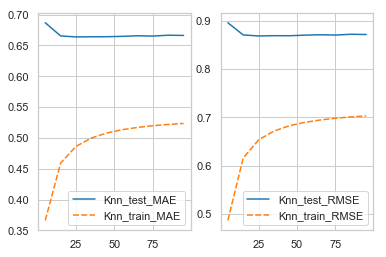

In [16]:
fig, axs = plt.subplots(ncols=2)
sns.set(style="whitegrid")
sns.lineplot(data = Knn_MAE, palette="tab10",ax = axs[0])
sns.lineplot(data = Knn_RMSE, palette="tab10",ax = axs[1])

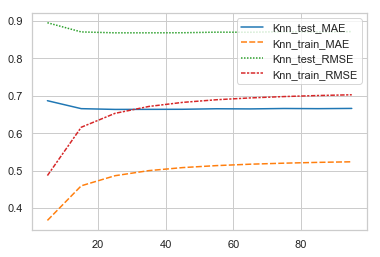

In [37]:
Knn = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE,Knn_test_RMSE, Knn_train_RMSE]),
                   columns=['Knn_test_MAE', 'Knn_train_MAE','Knn_test_RMSE', 'Knn_train_RMSE'])
Knn.index = neighbor_size
sns.lineplot(data = Knn, palette="tab10")

### size

In [30]:
param_grid = {'k': neighbor_size}
knn_gs=GridSearchCV(KNNBaseline,param_grid)
knn_gs.fit(data)

bestk = knn_gs.best_params['mae']['k']

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [31]:
knn_size_effect=[]
Knn_time = []
Knn_train_MAE=[]
Knn_test_MAE=[]
Knn_train_RMSE=[]
Knn_test_RMSE=[]
for n in new_size:
    new_df=df.sample(n=n)
    data=Dataset.load_from_df(new_df,reader=reader)
    algo=KNNBaseline(k=bestk)
    c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
    Knn_time.append(np.mean(c_v['fit_time']))
    Knn_train_MAE.append(np.mean(c_v['train_mae']))
    Knn_test_MAE.append(np.mean(c_v['test_mae']))
    Knn_train_RMSE.append(np.mean(c_v['train_rmse']))
    Knn_test_RMSE.append(np.mean(c_v['test_rmse']))
knn_size_effect=[Knn_time,Knn_train_MAE,Knn_test_MAE,Knn_train_RMSE,Knn_test_RMSE]  


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8730  0.8770  0.8644  0.8660  0.8737  0.8675  0.8635  0.8653  0.8717  0.8651  0.8687  0.0045  
MAE (testset)     0.6693  0.6698  0.6605  0.6658  0.6663  0.6634  0.6557  0.6607  0.6638  0.6614  0.6637  0.0041  
RMSE (trainset)   0.6708  0.6713  0.6716  0.6715  0.6711  0.6713  0.6716  0.6724  0.6719  0.6719  0.6715  0.0004  
MAE (trainset)    0.4991  0.4994  0.4996  0.4996  0.4991  0.4

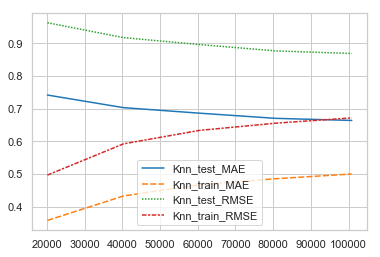

In [35]:
Knn_newsize = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE,Knn_test_RMSE, Knn_train_RMSE]),
                   columns=['Knn_test_MAE', 'Knn_train_MAE','Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_newsize.index = new_size
sns.lineplot(data = Knn_newsize, palette="tab10")

### SVD

In [108]:
learning_rate=np.arange(0.001,0.01,0.002)
regularization=np.arange(0.01,0.1,0.02)
n_factors=np.arange(50,200,50)
n_epochs=np.arange(10,100,20)

svd_result=[]
for lr in learning_rate:
    SVD_time = []
    SVD_train_MAE=[]
    SVD_test_MAE=[]
    SVD_train_RMSE=[]
    SVD_test_RMSE=[]
    
    for reg in regularization:
        algo=SVD(n_epochs =50,lr_all=lr,reg_all=reg)
        c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
        SVD_time.append(np.mean(c_v['fit_time']))
        SVD_train_MAE.append(np.mean(c_v['train_mae']))
        SVD_test_MAE.append(np.mean(c_v['test_mae']))
        SVD_train_RMSE.append(np.mean(c_v['train_rmse']))
        SVD_test_RMSE.append(np.mean(c_v['test_rmse']))
    svd_result.append([SVD_time,SVD_train_MAE,SVD_test_MAE,SVD_train_RMSE,SVD_test_RMSE])


Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8908  0.8782  0.8792  0.8880  0.8851  0.8732  0.8760  0.8817  0.8707  0.8826  0.8805  0.0060  
MAE (testset)     0.6821  0.6789  0.6756  0.6850  0.6852  0.6724  0.6721  0.6791  0.6711  0.6803  0.6782  0.0049  
RMSE (trainset)   0.7596  0.7629  0.7621  0.7604  0.7616  0.7621  0.7614  0.7585  0.7627  0.7605  0.7612  0.0013  
MAE (trainset)    0.5868  0.5891  0.5885  0.5869  0.5878  0.5886  0.5877  0.5859  0.5892  0.5870  0.5878  0.0010  
Fit time          15.65   14.36   15.07   13.73   13.78   13.74   13.75   13.73   13.74   14.96   14.25   0.68    
Test time         0.11    0.06    0.06    0.06    0.12    0.05    0.06    0.06    0.12    0.11    0.08    0.03    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fol

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9055  0.8994  0.8936  0.8854  0.8875  0.9049  0.8962  0.8914  0.9062  0.8989  0.8969  0.0070  
MAE (testset)     0.6953  0.6932  0.6848  0.6809  0.6814  0.6975  0.6884  0.6798  0.6953  0.6882  0.6885  0.0063  
RMSE (trainset)   0.2552  0.2560  0.2552  0.2578  0.2569  0.2568  0.2573  0.2574  0.2562  0.2570  0.2566  0.0009  
MAE (trainset)    0.1938  0.1946  0.1935  0.1956  0.1954  0.1955  0.1956  0.1957  0.1948  0.1954  0.1950  0.0008  
Fit time          15.34   13.72   13.66   13.54   13.58   13.55   13.54   13.61   13.58   15.94   14.01   0.83    
Test time         0.11    0.12    0.12    0.05    0.06    0.05    0.12    0.12    0.13    0.07    0.09    0.03    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fol

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8992  0.9159  0.9123  0.8868  0.9097  0.9129  0.9013  0.8984  0.9083  0.8822  0.9027  0.0108  
MAE (testset)     0.6930  0.7010  0.7032  0.6848  0.6998  0.7035  0.6910  0.6920  0.6989  0.6777  0.6945  0.0080  
RMSE (trainset)   0.1474  0.1484  0.1486  0.1484  0.1471  0.1486  0.1482  0.1484  0.1480  0.1488  0.1482  0.0005  
MAE (trainset)    0.1079  0.1086  0.1087  0.1085  0.1077  0.1086  0.1086  0.1087  0.1085  0.1089  0.1085  0.0003  
Fit time          13.55   13.82   14.73   15.29   14.90   14.44   13.58   13.84   14.63   15.71   14.45   0.70    
Test time         0.05    0.12    0.12    0.06    0.06    0.12    0.05    0.05    0.07    0.06    0.08    0.03    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fol

In [109]:
%store svd_result

Stored 'svd_result' (list)


In [110]:
learning_rate

array([0.001, 0.003, 0.005, 0.007, 0.009])

In [111]:
regularization

array([0.01, 0.03, 0.05, 0.07, 0.09])

In [112]:
svd_result

[[[14.251072597503661,
   14.585221552848816,
   14.489236998558045,
   13.578053903579711,
   13.88280942440033],
  [0.5877546222938628,
   0.60646865141164,
   0.617457269426116,
   0.6249641351330155,
   0.6308887884789554],
  [0.6781815783817794,
   0.6754648747532592,
   0.6750055347696114,
   0.675026369267683,
   0.6753046841127965],
  [0.7611765822219977,
   0.7851960236310729,
   0.7994591394782313,
   0.8090880106203769,
   0.8168435453713363],
  [0.8805490570564848,
   0.8770089763145081,
   0.8764903223476835,
   0.8758160997765451,
   0.8764265055232473]],
 [[13.6456622838974,
   13.6341552734375,
   13.642613530158997,
   25.556666016578674,
   13.723885655403137],
  [0.32769728207333615,
   0.42493487171520555,
   0.4930107713825488,
   0.540413303561696,
   0.5711240725853632],
  [0.6800908907482868,
   0.6605630862133927,
   0.6578253144786673,
   0.6589748551686196,
   0.6610616138046304],
  [0.42590533910673656,
   0.5442082579620295,
   0.6321033495574657,
   0.6943

learning rate

In [170]:
svd_time = []
svd_train_MAE = []
svd_test_MAE = []
svd_train_RMSE = []
svd_test_RMSE = []
for row in svd_result:
    svd_time.append(row[0])
    svd_train_MAE.append(np.mean(row[1]))
    svd_test_MAE.append(np.mean(row[2]))
    svd_train_RMSE.append(np.mean(row[3]))
    svd_test_RMSE.append(np.mean(row[4]))

In [156]:
svd_time = pd.DataFrame(svd_time)
svd_time.index = learning_rate.round(3)
svd_time.index.name = 'learning_rate'
svd_time.columns = regularization.round(2)
svd_time.columns.name = 'regularization'

In [153]:
svd_time

regularization,0.01,0.03,0.05,0.07,0.09
learning_rate,,,,,
0.001,14.251073,14.585222,14.489237,13.578054,13.882809
0.003,13.645662,13.634155,13.642614,25.556666,13.723886
0.005,14.005518,14.569000,15.460267,14.119882,13.581711
0.007,13.743436,14.847586,15.350234,15.343077,14.536579
0.009,14.447281,14.726490,14.860003,13.876083,13.903970


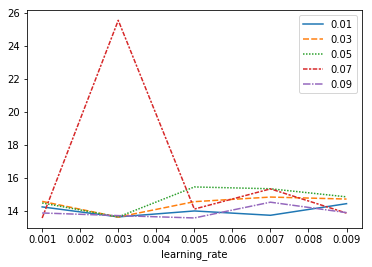

In [154]:
#svd-time
#sns.lineplot(data = svd_time,hue = regularization,palette="tab10")
sns.lineplot(data = svd_time, palette="tab10")

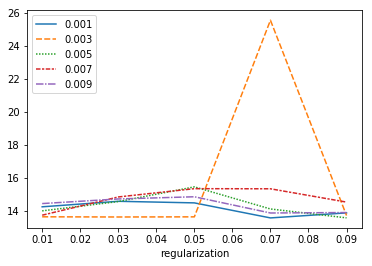

In [157]:
sns.lineplot(data = svd_time.transpose(), palette="tab10")

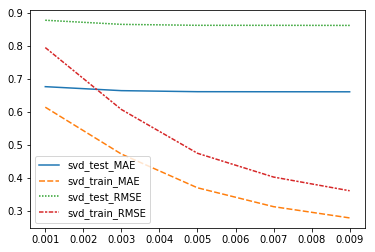

In [171]:
svd_learning_rate = pd.DataFrame(np.column_stack([svd_test_MAE, svd_train_MAE,svd_test_RMSE, svd_train_RMSE]),
                   columns=['svd_test_MAE', 'svd_train_MAE','svd_test_RMSE', 'svd_train_RMSE'])
svd_learning_rate.index = learning_rate
sns.lineplot(data = svd_learning_rate, palette="tab10")

regularization

In [312]:
SVD_result = pd.Panel(svd_result).to_frame()

/Users/ycr/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [319]:
SVD_result.index.names = ['type','regularization']
SVD_result.index.set_levels= ['time','train_MAE','test_MAE','train_RMSE','test_RMSE']

In [320]:
SVD_result.columns = learning_rate.round(3)
SVD_result.columns.name = 'learning_rate'

In [332]:
SVD_result

learning_rate            0.001      0.003      0.005      0.007      0.009
type regularization                                                       
0    0               14.251073  13.645662  14.005518  13.743436  14.447281
     1               14.585222  13.634155  14.569000  14.847586  14.726490
     2               14.489237  13.642614  15.460267  15.350234  14.860003
     3               13.578054  25.556666  14.119882  15.343077  13.876083
     4               13.882809  13.723886  13.581711  14.536579  13.903970
1    0                0.587755   0.327697   0.194995   0.137753   0.108473
     1                0.606469   0.424935   0.298933   0.235871   0.201588
     2                0.617457   0.493011   0.385781   0.323788   0.286488
     3                0.624964   0.540413   0.455997   0.399293   0.362750
     4                0.630889   0.571124   0.509422   0.462334   0.429088
2    0                0.678182   0.680091   0.688483   0.692187   0.694497
     1                0.675465   0.660563   0.660506   0.662908   0.662903
     2                0.675006   0.657825   0.651283   0.650788   0.651054
     3                0.675026   0.658975   0.650379   0.647448   0.646151
     4                0.675305   0.661062   0.652092   0.648380   0.646414
3    0                0.761177   0.425905   0.256592   0.184021   0.148175
     1                0.785196   0.544208   0.382697   0.303983   0.262561
     2                0.799459   0.632103   0.492859   0.415662   0.370700
     3                0.809088   0.694370   0.583338   0.511812   0.467613
     4                0.816844   0.736029   0.653184   0.592561   0.551275
4    0                0.880549   0.885232   0.896903   0.901379   0.902704
     1                0.877009   0.862314   0.862706   0.864826   0.865205
     2                0.876490   0.857132   0.850666   0.850860   0.850643
     3                0.875816   0.858448   0.848706   0.845946   0.844848
     4                0.876427   0.860634   0.850361   0.846118   0.844436

In [339]:
param_grid = {'lr_all': learning_rate,'reg_all':regularization}
svd_gs=GridSearchCV(SVD,param_grid)
svd_gs.fit(data)

bestlr = svd_gs.best_params['mae']['lr_all']
bestreg=svd_gs.best_params['mae']['reg_all']

In [106]:
SVD_time = []
SVD_train_MAE=[]
SVD_test_MAE=[]
SVD_train_RMSE=[]
SVD_test_RMSE=[]
SVD_size_effect=[]
for n in new_size:
    new_df=df.sample(n=n)
    data=Dataset.load_from_df(new_df,reader=reader)
    algo=SVD(n_epochs =50,lr_all=bestlr,reg_all=bestreg)
    c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
    SVD_time.append(np.mean(c_v['fit_time']))
    SVD_train_MAE.append(np.mean(c_v['train_mae']))
    SVD_test_MAE.append(np.mean(c_v['test_mae']))
    SVD_train_RMSE.append(np.mean(c_v['train_rmse']))
    SVD_test_RMSE.append(np.mean(c_v['test_rmse']))
SVD_size_effect.append([SVD_time,SVD_train_MAE,SVD_test_MAE,SVD_train_RMSE,SVD_test_RMSE])

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9233  0.9496  0.9296  0.9280  0.9413  0.9477  0.9141  0.9087  0.9402  0.9336  0.9316  0.0129  
MAE (testset)     0.7108  0.7484  0.7219  0.7287  0.7293  0.7407  0.7115  0.7133  0.7393  0.7194  0.7263  0.0126  
RMSE (trainset)   0.7896  0.7887  0.7895  0.7891  0.7869  0.7898  0.7892  0.7926  0.7870  0.7881  0.7890  0.0015  
MAE (trainset)    0.6161  0.6148  0.6144  0.6145  0.6134  0.6151  0.6141  0.6172  0.6118  0.6139  0.6145  0.0014  
Fit time          2.90    3.07    2.86    2.83    2.80    2.96    3.04    2.78    2.88    2.82    2.89    0.10    
Test time         0.01    0.01    0.01    0.01    0.01    0.02    0.01    0.01    0.01    0.01    0.01    0.00    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fol

In [342]:
%store SVD_size_effect

Stored 'SVD_size_effect' (list)


In [340]:
bestlr

0.009000000000000001

In [341]:
bestreg

0.06999999999999999

In [336]:
SVD_size_effect

[[[2.8942103385925293,
   5.720335292816162,
   9.041515731811524,
   12.01565899848938,
   13.82228126525879],
  [0.6145251473915534,
   0.6010886472278548,
   0.5957145171888809,
   0.5910665915009248,
   0.5880322658274679],
  [0.7263185635090597,
   0.7013455615888908,
   0.6912625895740026,
   0.6825705336833628,
   0.6774695958294334],
  [0.789039934618068,
   0.7770248687744223,
   0.7696728399406192,
   0.7647064822067816,
   0.7614175934140806],
  [0.9316125008788628,
   0.9072755686603354,
   0.8938868109558019,
   0.8854374909609424,
   0.8795866931205916]]]

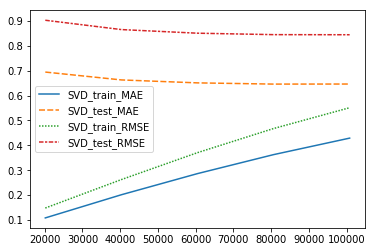

In [338]:
svd_newsize = pd.DataFrame(np.column_stack([SVD_train_MAE, SVD_test_MAE,SVD_train_RMSE, SVD_test_RMSE]),
                   columns=['SVD_train_MAE', 'SVD_test_MAE','SVD_train_RMSE', 'SVD_test_RMSE'])
svd_newsize.index = new_size
sns.lineplot(data = svd_newsize, palette="tab10")